# Using S-Parameters to simulate whole circuits

It is computationally expensive to simulate every device in a circuit simultaneously using MEEP or other FDTD methods. Instead, we can simulate each individual component once in order to generate a table of s-parameters and their corresponding frequencies. With the frequency-dependent s-parameters known for each element in a photonic circuit, we can cascade them together to determine the steady-state behavior of the circuit as a whole.

The s-parameters for each device form a matrix of complex numbers (phase and magnitude), with one column per input port and one row per output port. Consecutive photonic circuit elements are cascaded by multiplying the corresponding matrices together:


# Maxwell's Equations

Example s-parameter calculation with a 3-component photonic circuit with two external inputs and two external outputs:

$$\left(\begin{matrix}
out_1 \\ out_2
\end{matrix}\right)
=
\left(\begin{matrix}
A_{11} & A_{12} & A_{13}\\
A_{21} & A_{22} & A_{23}\\
\end{matrix}\right)
\left(\begin{matrix}
B_{11}\\
B_{21}\\
B_{31}\\
\end{matrix}\right)
\left(\begin{matrix}
C_{11} & C_{12}\\
\end{matrix}\right)
\left(\begin{matrix}
in_1 \\ in_2\\
\end{matrix}\right)
$$

# Simphony
Simphony is a python module designed to automate the process of running the s-parameter cascade, with a set of basic photonic building-blocks already included and efficient calculation of frequency-dependent s-parameters for these blocks.

In [1]:
#Library containing models of basic components
from simphony.library import siepic           

#Class representing a photonic circuit
from simphony.netlist import Subcircuit

#Class representing a photonic circuit frequency sweep simulation
from simphony.simulation import SweepSimulation

#Helper function
from simphony.tools import freq2wl

import matplotlib.pyplot as plt

# Creating a Photonic Circuit

A circuit (Subcircuit) is comprised of Elements. Each element is an instance of a Model. Multiple identical elements may be instantiated from the same Model

Circuit design approach:
 - Define each unique Model used
 - Create Subcircuit
 - Used Subcircuit.add to automatically instantiate elements from the predefined models
 
Once a circuit is designed, it may be simulated by specifying frequency start and end points

# Example: Mach-Zehnder Modulator
 - Grating coupler on either side
 - Two couplers with different-lengthed waveguides between them

In [2]:
#Define all photonic elements using basic library components
gratingCoupler = siepic.ebeam_gc_te1550()
longWaveguide  = siepic.ebeam_wg_integral_1550(length=200e-6)
shortWaveguide = siepic.ebeam_wg_integral_1550(length=100e-6)
coupler        = siepic.ebeam_bdc_te1550() #gap = 2e-7, length=10e-6
terminator     = siepic.ebeam_terminator_te1550()

In [3]:
#Create the circuit and give it a name
circuit = Subcircuit("MZM")

#Create each Element from its Model, giving each one a UNIQUE name
e = circuit.add([
    (gratingCoupler,    "input"),
    (gratingCoupler, "secInput"),
    (       coupler, "splitter"),
    ( longWaveguide,     "long"),
    (shortWaveguide,    "short"),
    (       coupler, "combiner"),
    (gratingCoupler,   "output"),
    (gratingCoupler,     "term")
])

# Pins

Each port of a circuit element is called a pin in Simphony and assigned a name. Pins may be connected together within a subcircuit, and any disconnected pins are available externally as overall inputs/outputs. The default pin names may be found in the documentation at:

https://simphonyphotonics.readthedocs.io/en/stable/index.html

They are typically of the form "n1", "n2", "n3", etc.

It is helpful to assign externally accessibly pins you want to access unique names. The "n2" pins of the grating couplers represent their external connections.

In [4]:
circuit.elements["input"].pins["n2"] = "input"
circuit.elements["secInput"].pins["n2"] = "secInput"
circuit.elements["output"].pins["n2"] = "output"

While it is not required, your code can be more sensible if you also assign the pin names of some of the internal elements. These may all be assigned at once:

In [5]:
circuit.elements['splitter'].pins = ("mainInput", "secInput",
                                    "output1", "output2")
circuit.elements['combiner'].pins = ("input1", "input2",
                                    "mainOutput", "secOutput")

# Connections
Each pin may be connected to one other pin using circuit.connect or circuit.connect_many. Either function accepts a desired connection in the form of a tuple of length 4:

(first element name, first element port, connecting element name, connecting element port)

The order does not matter

In [6]:
# circuit.connect_many([
#     (   "input",         "n1", "splitter", "mainInput"),
#     ("secInput",         "n1", "splitter",  "secInput"),
#     ("splitter",    "output1",  "output",        "n1"),
#     ("splitter",    "output2",    "term",        "n1"),
# ])

In [7]:
# circuit.connect_many([
#     (   "input",         "n1", "output", "n1"),
# ])

In [8]:
circuit.connect_many([
    (   "input",         "n1", "splitter", "mainInput"),
#    ("secInput",         "n1", "splitter",  "secInput"),
    ("splitter",    "output1",     "long",        "n1"),
    ("splitter",    "output2",    "short",        "n1"),
    (    "long",         "n2", "combiner",    "input1"),
    (   "short",         "n2", "combiner",    "input2"),
    ("combiner", "mainOutput",   "output",        "n1"),
#    ("combiner",  "secOutput",     "term",        "n1")
])

# Simulation

With the circuit fully specified, we can now simulate it. We use a SweepSimulation that calculates the input/output relationship for a series of linearly spaced wavelengths:

In [9]:
simulation = SweepSimulation(circuit, 1500e-9, 1600e-9)
result     = simulation.simulate()

# Extract and Plot Data

We can extract the data from the result object using the pin names and plot it

In [10]:
f, s = result.data("input", "output")
w = freq2wl(f)

Text(0, 0.5, 'Output Magnitude Proportion')

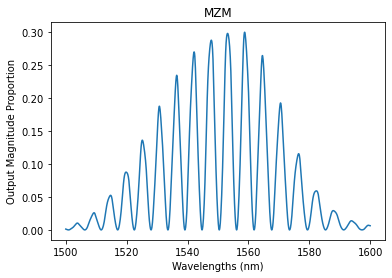

In [11]:
plt.plot(w*10**9,s)
plt.title("MZM")
plt.xlabel("Wavelengths (nm)")
plt.ylabel("Output Magnitude Proportion")